# Choosing a frequency grid

If we are working on a evenly sampled time series, it is easy to choose a frequency grid for the computation of the fourier transform or the PSD. This is a little more complicated in the case of unevenly sampled data. Choose a correct frequency grid with the optimal amount of information requires of:
* whe need to know what is the duratio of the observed time series, this represent the minimum frequency that can complete a half period in the observation window. $f_{min}=1/T$
* Known what is the maximum frequency that can give to us new and relevant information. This quantity is descrived by the nyquist-shannon sampling theorem and is called "nyquist limit", it is usually represented by half of the sampling rate for the evenly sampled data, in the case of unevenly sampled data it's hard to get the true nyquist limit. $f_{max} \approx 0.5 f_s$
* finally we need a frequnecy step $df$ such that can give the optimal amount of information, if we choose a too small $df$ we get repeated information and if we choose a too big $df$ we lost information. Usually an optimal value is to choose the minimum frequency $df = f_{min}$ but in the case of unevenly sampled data use an oversampling factor since the behavior of the relevant information is not so regular. $df = f_{min}/ \gamma $


Here we can know easly $f_{min}$ and thus $df$ if we don't care about de oversampling factor $\gamma$, the important thing is the $f_{max}$. From literature there are several methods to estimate a nyquist limit, but their are computationally expensive and we can use a more simplest method. We just choose the maximum frequency following directly the nyquist-shannon sampling theorem which states: 

_If a function x(t) contains no frequencies higher than B hertz, it is completely determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart._

this can be seen as, if we have a sampling rate $f_s$, then we cannot describe frequencies higher than $f_s/2$ and thus we just use this as the maximum frequency even for the case of unevenly sampled data (in which we use an average sampling rate)

here we are going to show with a linear time series taken on evenly and unevenly times.

In [2]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples

Text(0,0.5,'data')

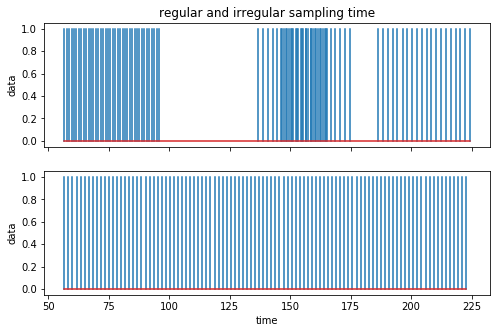

In [3]:
def random_comb(N, basic_dt, struct="slight"):
    t = TimesSamples(n=N, delta=basic_dt, struct=struct)
    data = np.ones(N)
    return t, data
N = 100
times, data = random_comb(N, 1.0, struct="automix")
times2, data2 = random_comb(N, times.duration/N, struct="regular")
times2 += times.min()
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax1.stem(times, data, markerfmt=' ')
ax2.stem(times2, data2, markerfmt=' ')
ax1.set_title("regular and irregular sampling time")
ax2.set_xlabel("time")
ax2.set_ylabel("data")
ax1.set_ylabel("data")

In [4]:
# geting the frequency grid, can be obtained manually or by using the code in the package.
def f_grid(time, gamma=1):
    f_min = 1/time.duration
    df = f_min / gamma
    f_max = 0.5 * time.average_fs
    return np.linspace(f_min, f_max, int(round(f_max/df))), FrequencySamples(input_time=time,
                                                                             minimum_frequency=f_min,
                                                                             maximum_frequency=f_max, 
                                                                             samples_per_peak=gamma)
f_1, f1 = f_grid(times)
f_2, f2 = f_grid(times2) # here the presition fails.
print(times.average_fs)
press = 4 # so we define some grade of presition.
print(np.array([round(f_1[i], press) == round(f1[i], press) for i in range(len(f2))]).all())
print(np.array([round(f_2[i], press) == round(f2[i], press) for i in range(len(f2))]).all())

0.596328112299123
True
True


In [5]:
# doing the fourier transform, using mfilter.types.timeseries.TimeSeries.to_frequencyseries
# or can be done by using the linear regressor directly form sklearn.

#define time series
T1 = TimeSeries(data, times=times)
T2 = TimeSeries(data2, times=times2)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.reset()
reg.create_dict(times, f1)
F1 = T1.to_frequencyseries(reg=reg)
reg.reset()
reg.create_dict(times2, f2)
F2 = T2.to_frequencyseries(reg=reg)

observation: Change the frequency grid should not affect the common information (common frequencies should remains with same value)

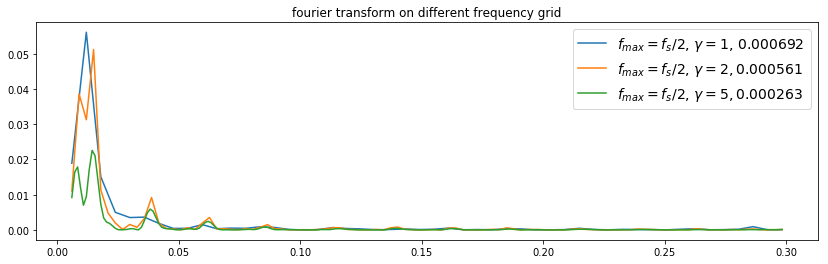

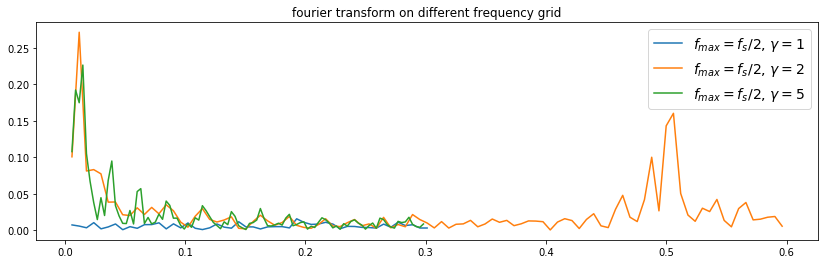

In [14]:
f_max = times.average_fs * 0.5
f_min = 1/times.duration
f1_2 = FrequencySamples(input_time=times,
                        minimum_frequency=f_min,
                        maximum_frequency=f_max, 
                        samples_per_peak=2)
f1_3 = FrequencySamples(input_time=times, 
                        minimum_frequency=f_min, 
                        maximum_frequency=f_max, 
                        samples_per_peak=5)

reg.reset()
reg.create_dict(times, f1_2)
F1_2 = T1.to_frequencyseries(reg=reg)
reg.reset()
reg.create_dict(times, f1_3)
F1_3 = T1.to_frequencyseries(reg=reg)
plt.figure(figsize=(14, 4))
s1 = (np.abs(F1)**2).sum() * f1.df
s2 = (np.abs(F1_2)**2).sum() * f1_2.df
s3 = (np.abs(F1_3)**2).sum() * f1_3.df
plt.plot(f1, abs(F1)**2, label=r"$f_{max}=f_s/2$, $\gamma=1$, " + str(round(s1, 6)))
plt.plot(f1_2, abs(F1_2)**2, label=r"$f_{max}=f_s/2$, $\gamma=2, $" + str(round(s2, 6)))
plt.plot(f1_3, abs(F1_3)**2, label=r"$f_{max}=f_s/2$, $\gamma=5, $" + str(round(s3, 6)))
plt.title("fourier transform on different frequency grid")
plt.legend(fontsize=14)

f_max2 = times2.average_fs * 0.5
f_min2 = 1/times2.duration
f2_2 = FrequencySamples(input_time=times2,
                        minimum_frequency=f_min,
                        maximum_frequency=f_max * 2, 
                        samples_per_peak=1)
f2_3 = FrequencySamples(input_time=times2, 
                        minimum_frequency=f_min, 
                        maximum_frequency=f_max, 
                        samples_per_peak=2)


reg.reset()
reg.create_dict(times, f2_2)
F2_2 = T2.to_frequencyseries(reg=reg)
reg.reset()
reg.create_dict(times, f2_3)
F2_3 = T2.to_frequencyseries(reg=reg)
plt.figure(figsize=(14, 4))
plt.plot(f2, abs(F2), label=r"$f_{max}=f_s/2$, $\gamma=1$")
plt.plot(f2_2, abs(F2_2), label=r"$f_{max}=f_s/2$, $\gamma=2$")
plt.plot(f2_3, abs(F2_3), label=r"$f_{max}=f_s/2$, $\gamma=5$")
plt.title("fourier transform on different frequency grid")
plt.legend(fontsize=14)

This shows that change the frequency grid DOES affect the fourier transform since affect the regression method by changing the coeficient/features. We observe that the changes are small oscilations but can be bigger if the difference in the frequency grid are more notorious, this is for the case of irregular samples. Then it is importat to choose wisely the grid to use.

Observation: Evenly and unevenly sampled data will have small diferences in their 

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax1.plot(f1, F1.real)
ax1.plot(f2, F2.real)
ax2.plot(f1, F1.imag)
ax2.plot(f2, F2.imag)
ax1.set_title("Fourier Transform splited in real and imaginary part")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Imaginary part")
ax1.set_ylabel("Real part")